# Dogs vs. Cats with Tensorflow and Python

![](data/woof_meow.jpg)

I have chosen the Dogs vs. Cats data set from the popular Kaggle competition for the small demo.

For traditional ML this is a difficult problem, there is so much overlap between cats and dogs being colour, texture and shape. For Deep Learning this is a fairly simple problem, the cutting edge models obtains a 97% accuracy, and my toy model for the purpose of showing you some code obtains a 90% accuracy.

## Dependencies

In [1]:
%matplotlib inline
import matplotlib

import os
from skimage import color, io
from scipy.misc import imresize, imsave
from glob import glob
import random as rnd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches  

from sklearn.model_selection import train_test_split

## Helper methods

In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
def save_img(file_name):
    plt.savefig(file_name, format='png', dpi=300)

In [4]:
def fetch_batch(X, iteration, batch_size):
    i = iteration * batch_size
    j = iteration * batch_size + batch_size
    return X[i:j]

In [5]:
def get_label(pred, actual):
    label = ''
    if pred == actual:
        if actual == 0:
            label = 'Cat'
        else:
            label = 'Dog'
    else:
        if actual == 0:
            label = 'Dog *'
        else:
            label = 'Cat *'
    return label

## Preprocess the labeled data

In [6]:
data_path = './data/train'
image_size = 128

cat_files_path = os.path.join(data_path + '/cats', 'cat.*.jpg')
dog_files_path = os.path.join(data_path + '/dogs', 'dog.*.jpg')

cat_files = sorted(glob(cat_files_path))
dog_files = sorted(glob(dog_files_path))

file_count = len(cat_files) + len(dog_files)
print('Dog files found: {}'.format(len(dog_files)))
print('Cat files found: {}'.format(len(cat_files)))
file_count = 20000

images = np.zeros((file_count, image_size, image_size, 3), dtype='float64')
labels = np.zeros(file_count)
count = 0
for f in cat_files[:10000]:
    try:
        img = io.imread(f)
        new_img = imresize(img, (image_size, image_size, 3))
        new_img = np.array(new_img) / 255.
        images[count] = new_img
        labels[count] = 0
        count += 1
    except:
        continue

for f in dog_files[:10000]:
    try:
        img = io.imread(f)
        new_img = imresize(img, (image_size, image_size, 3))
        new_img = np.array(new_img) / 255.
        images[count] = np.array(new_img)
        labels[count] = 1
        count += 1
    except:
        continue
        


Dog files found: 12500
Cat files found: 12500


In [7]:
images.shape

(20000, 128, 128, 3)

In [8]:
labels.shape

(20000,)

## Data insights

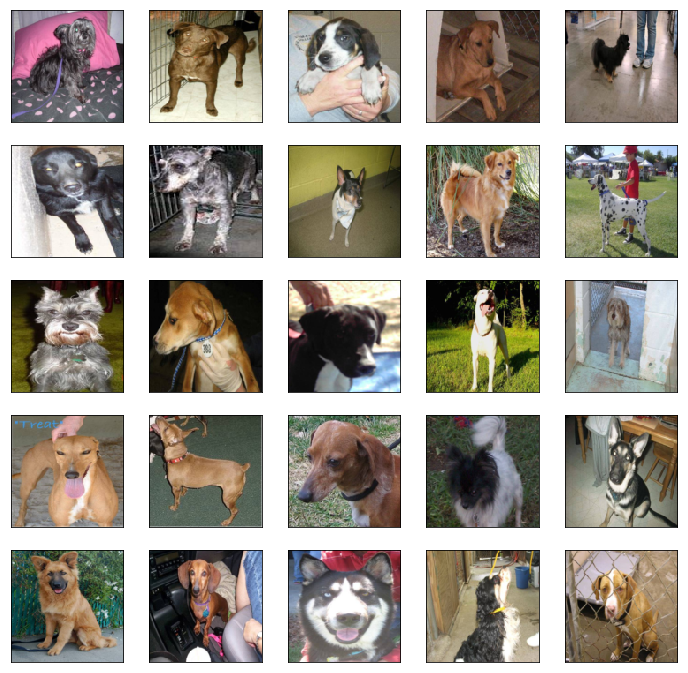

In [10]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

for num,img_data in enumerate(images[10000:10025]):
    sub = fig.add_subplot(5,5,num+1)
    sub.imshow(img_data)
    #plt.title('cat', fontsize=18)
    sub.axes.get_xaxis().set_visible(False)
    sub.axes.get_yaxis().set_visible(False)
plt.show()


## Convolutions

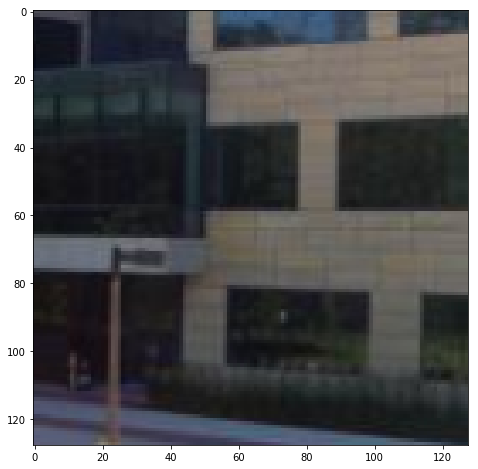

In [11]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)

img = io.imread('data/building.jpg')
img = img[150:280, 150:280]
new_img = imresize(img, (image_size, image_size, 3))
new_img = np.array(new_img) / 255.

plt.imshow(new_img)
plt.show()

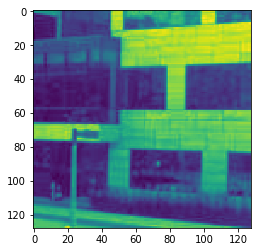

In [12]:
height, width, channels = new_img.shape
img_gray = new_img.mean(axis=2).astype(np.float32)
img_gray2 = img_gray.reshape(1, height, width, 1)

plt.imshow(img_gray)
plt.show()

## Filters

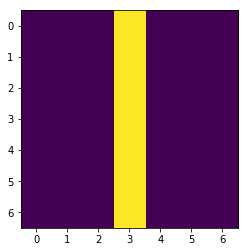

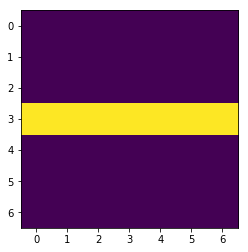

In [13]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
fmap[:, :, 0, 0]
plt.imshow(fmap[:, :, 0, 0])
plt.show()
plt.imshow(fmap[:, :, 0, 1])
plt.show()

In [14]:
reset_graph()
height = 128
width = 128

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

In [15]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: img_gray2})

### Vertical

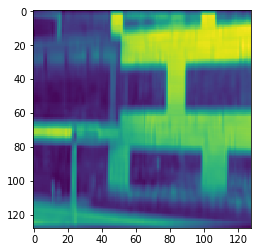

In [16]:
plt.imshow(output[0, :, :, 0])
plt.show()
#imsave('data/vertical.png', output[0, :, :, 0])

### Horizontal

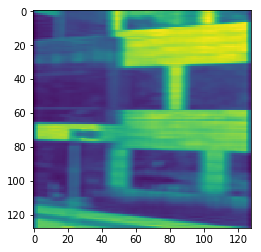

In [17]:
plt.imshow(output[0, :, :, 1])
plt.show()
#imsave('data/horizontal.png', output[0, :, :, 1])

## Train

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(images, labels, test_size=0.10, random_state=41)
X_val, X_test, y_val, y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=41)

In [19]:
X_train.shape

(18000, 128, 128, 3)

In [20]:
X_val.shape

(1000, 128, 128, 3)

In [21]:
X_test.shape

(1000, 128, 128, 3)

### The Model

In [27]:
def conv_maxpool(inputs, num_filters=32, name='conv-maxpool'):
    with tf.name_scope(name):
        conv = tf.layers.conv2d(
            inputs=inputs,
            filters=num_filters,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)

        pool = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
        return pool

In [28]:
with tf.name_scope('placeholders'):
        with tf.name_scope('X'):
            X = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name="X")
        with tf.name_scope('y'):
            y = tf.placeholder(tf.int32, shape=[None], name="y")

In [29]:
with tf.name_scope('model'):
        convmax1 = conv_maxpool(inputs=X, num_filters=32, name='conv-max-1')
        convmax2 = conv_maxpool(inputs=convmax1, num_filters=64, name='conv-max-2')
        convmax3 = conv_maxpool(inputs=convmax2, num_filters=128, name='conv-max-3')
        convmax4 = conv_maxpool(inputs=convmax3, num_filters=128, name='conv-max-4')

        with tf.name_scope('flat'):
            pool_flat = tf.reshape(convmax4, shape=[-1, 128 * 8 * 8])

        with tf.name_scope('fc-1'):
            dense = tf.layers.dense(inputs=pool_flat, units=1024, activation=tf.nn.relu)
        with tf.name_scope('drop-out-1'):
            dropout = tf.layers.dropout(inputs=dense, rate=0.5)

        # Logits Layer
        with tf.name_scope('logits-1'):
            logits = tf.layers.dense(inputs=dropout, units=2)

In [30]:
with tf.name_scope('ops-1'):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
        loss = tf.reduce_mean(xentropy)
        optimizer = tf.train.AdamOptimizer()
        training_op = optimizer.minimize(loss)
        predictor = tf.argmax(logits, 1)

In [31]:
with tf.name_scope('summary'):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

In [32]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
step = 0
prev_best = 0
num_epochs = 15
batch_size = 100
train_accs = []
val_accs = []
train_errs = []
val_errs = []
train_loss = []
val_loss = []
plt.ion()
plt.show()
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
feedback_step = 0
accs = []
errors = []

with tf.Session() as sess:
    init.run()
    for epoch in range(num_epochs):
        for i in range(len(X_train) // batch_size):
            X_train_batch = fetch_batch(X_train, i, batch_size)
            Y_train_batch = fetch_batch(Y_train, i, batch_size)
            
            sess.run(training_op, feed_dict={X: X_train_batch, y: Y_train_batch})

            step += 1
            
            if step % 20 == 0:    
                feedback_step += 1
                accs[:] = []
                errors[:] = []

                for j in range(len(X_val) // batch_size):
                    X_val_batch = fetch_batch(X_val, j, batch_size)
                    y_val_batch = fetch_batch(y_val, j, batch_size)

                    acc = sess.run(accuracy, feed_dict={X:X_val_batch, y: y_val_batch})
                    accs.append(acc)

                    error = sess.run(loss, feed_dict={X:X_val_batch, y: y_val_batch})
                    errors.append(error)

                val_acc = sum(accs)/len(accs)
                train_acc = sess.run(accuracy, feed_dict={X:X_train_batch, y: Y_train_batch})
                train_accs.append(train_acc)
                val_accs.append(val_acc)

                val_err = sum(errors)/len(errors)
                train_err = sess.run(loss, feed_dict={X:X_train_batch, y: Y_train_batch})
                train_errs.append(train_err)
                val_errs.append(val_err)

                steps = [x for x in range(feedback_step)]
                plt.subplot(2, 1, 1)
                plt.title('Accuracy')
                plt.plot(steps, val_accs, color='r')
                plt.plot(steps, train_accs, color='b')
                plt.ylabel('accuracy')
                
                plt.subplot(2, 1, 2)
                plt.title('Error')
                plt.plot(steps, val_errs, color='r')
                plt.plot(steps, train_errs, color='b')
                plt.ylabel('error')

                red_patch = mpatches.Patch(color='red', label='Validation')
                blue_patch = mpatches.Patch(color='blue', label='Train')

                plt.legend(handles=[red_patch, blue_patch], loc=4)

                print('{}-{} Train acc: {} Val acc: {}'.format(epoch, step, train_acc, val_acc))
                if val_acc > prev_best:
                    print('... save new best model')
                    prev_best = val_acc
                    save_path = saver.save(sess, "models/model-{}-{:2.2f}.ckpt".format(epoch, val_acc))
    plt.savefig('./data/training_acc.png')

## Loss and Accuracy

![](data/training_acc.png)

## Measure against the unseen test set

In [33]:
with tf.Session() as sess:
    #init.run()
    saver.restore(sess, './models/model-14-0.86.ckpt')
    
    correct = 0
    Y_pred = []
    
    acc = sess.run(accuracy, feed_dict={X:X_test, y: y_test})
    print('Test accuracy: {}'.format(acc))                
    
    
    predictions = predictor.eval(feed_dict={X: X_test[0:25], y: y_test[:25]})
    print('Predictions: {}'.format(predictions))
    
    num = 1
    fig = plt.figure()
    fig.set_figheight(12)
    fig.set_figwidth(12)
    for pred, _y, img in zip(predictions, y_test[:25], X_test[0:25]):
        sub = fig.add_subplot(5,5,num)
        sub.imshow(img)
        plt.title(get_label(pred, _y), fontsize=18)
        sub.axes.get_xaxis().set_visible(False)
        sub.axes.get_yaxis().set_visible(False)
        
        num += 1
    plt.show()


INFO:tensorflow:Restoring parameters from ./models/model-14-0.86.ckpt


NotFoundError: Key dense_2/bias/Adam_1 not found in checkpoint
	 [[Node: save_1/RestoreV2_38 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_38/tensor_names, save_1/RestoreV2_38/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_32/_81 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_233_save_1/RestoreV2_32", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save_1/RestoreV2_38', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-74f077792af3>", line 2, in <module>
    saver = tf.train.Saver()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 1056, in __init__
    self.build()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 1086, in build
    restore_sequentially=self._restore_sequentially)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_io_ops.py", line 669, in restore_v2
    dtypes=dtypes, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key dense_2/bias/Adam_1 not found in checkpoint
	 [[Node: save_1/RestoreV2_38 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_38/tensor_names, save_1/RestoreV2_38/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_32/_81 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_233_save_1/RestoreV2_32", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
